# Comparison of algortihms/ansatz in Li-H ground state search
## VQE
## AdaptVQE
## VHA
## Imaginary time evolution

##

In [16]:
#CHECK VERSIONS OF QISKIT: 'qiskit-terra': '0.19.0','qiskit-aer': '0.8.2','qiskit-nature': '0.2.0'
import qiskit
print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.18.2', 'qiskit-aer': '0.9.0', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.16.0', 'qiskit-aqua': '0.9.5', 'qiskit': '0.30.0', 'qiskit-nature': '0.2.0', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


In [17]:
import os
os.environ["TMPDIR"] = "/tmp"  # set the folder for temporary files
import sys 
sys.path.insert(0, '/home/gsilvi/.local/lib/python3.9/site-packages')

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
from qiskit_nature.algorithms import VQEUCCFactory,GroundStateEigensolver,AdaptVQE
from qiskit_nature.circuit.library import HartreeFock, UCCSD,UCC

from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP,L_BFGS_B,SPSA, COBYLA
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit.circuit.library import TwoLocal
from qiskit.test.mock import FakeVigo
# from qiskit.providers.aer.noise import NoiseModel
# from qiskit.providers.aer import AerSimulator,QasmSimulator

# import HQStyle
# HQStyle.import_all()
from qiskit_mod.qiskit_nat import VHA
from qiskit_mod.qiskit_ter import LinCombFullmod,LinCombMod

import numpy as np 
import time as time
import matplotlib.pyplot as plt



In [18]:
use_qlm = False #instead of Qiskit

use_remote_qlm = False

In [19]:
#'qiskit-terra': '0.18.2', 'qiskit-aer': '0.8.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-aqua': None, 
#'qiskit': '0.30.0', 'qiskit-nature': '0.2.0', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None

# from qat.qlmaas import QLMaaSConnection

# conn = QLMaaSConnection(hostname="qlm35e.neasqc.eu")
# conn.create_config()

In [20]:
#MYQLM addition
if use_qlm:
    print('Using QLM local Backend')
    from qat.interop.qiskit import QPUToBackend
    from qat.qpus import get_default_qpu,PyLinalg
    qpu_local = PyLinalg() #local
    qlm_qpu = qpu_local

    #my own function
    from qiskit_mod.wrapper2myqlm import *
    from qiskit_mod.my_junction import IterativeExplorationVQE,get_energy_evaluation_QLM
    VQE.get_energy_evaluation = get_energy_evaluation_QLM #override the function, class-wide
    plugin_in_use = IterativeExplorationVQE

    
    if use_remote_qlm:
        print('Using QLM remote Backend')
        
        from qlmaas.qpus import LinAlg
        from qlmaas.plugins import IterativeExplorationVQE as IterativeExplorationVQEremote
        qpu_remote = LinAlg() #remote
        qlm_qpu = qpu_remote
        plugin_in_use = IterativeExplorationVQEremote
else:
    print('Using Qiskit local Backend')



Using Qiskit local Backend


In [24]:
# %%pycodestyle
distances = np.arange(1, 4.5, 1)  # angstrom distance


# Initialize qubit converter
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)  # two qubit reduction doesn`t work with Jordan-WignerMapper()

# Initialize Exact solvers & VQE solver
numpy_solver = NumPyMinimumEigensolver()

shots=1024
# NOISE
seed = 24
usenoise=False  #HERE CHOOSE TO USE THE NOISE 
backend = Aer.get_backend('aer_simulator')
backend_sv = Aer.get_backend('statevector_simulator')
if usenoise:
    device_backend = FakeVigo()
    device = QasmSimulator.from_backend(device_backend)
    coupling_map = device.configuration().coupling_map
    noise_model = NoiseModel.from_backend(device)
    basis_gates = noise_model.basis_gates
    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,shots=shots,  max_credits=None) # max_credits=None necessary with myqlm
else:
    quantum_instance = QuantumInstance(backend=backend, shots=shots,  max_credits=None)
    



# Optimizer
optimizer = L_BFGS_B(maxiter=1000)
#optimizer = COBYLA(maxiter=1000)
#optimizer = SPSA(maxiter=100)


# vha solver
trotter_steps = 3
time_step_size = 1.
# prepare intial point for VHA, inspired by adiabatic evolution
ip = []
for i in range(trotter_steps):
    ip.append(time_step_size*((i+1)/trotter_steps))  # param for H_ex = V
    ip.append(time_step_size)                        # param for H_hop = H_0
    ip.append(time_step_size)                        # param for H_diag = H_0

print('Initial parameter for VHA, '+str(trotter_steps)+'*(H_ex,H_op,H_diag)=', ip)

print('Range of distance to compute:',distances)

# print('quantum_instance:',quantum_instance)

Initial parameter for VHA, 3*(H_ex,H_op,H_diag)= [0.3333333333333333, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0]
Range of distance to compute: [1. 2. 3. 4.]


In [25]:
#%%pycodestyle

exact_energies, hf_energies, vqe_energies, adapt_vqe_energies, Ievo_energies, Ievo_params, vqe_params, adapt_vqe_params, vha_energies, vha_params = ([] for i in range(10))

# Molecule
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
orbitals_to_remove = [4,5]

for i, bond_distance in enumerate(distances):  # loop over distances
    print('\n step', i, ', bond_distance=', bond_distance)
    molecule_set = molecule.format(bond_distance/2)
    driver = PySCFDriver(atom=molecule_set, unit=UnitsType.ANGSTROM, basis='sto3g')
    #qmolecule = driver.run()
    es_problem = ElectronicStructureProblem(driver,q_molecule_transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=orbitals_to_remove)])
    second_q_op = es_problem.second_q_ops()
    qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles) #this line is useful for initialize the converter and get the right hartree-fock number of qubits
    
    particle_number = es_problem.properties_transformed.get_property("ParticleNumber")
    #particle_number = es_problem.grouped_property_transformed.get_property("ParticleNumber")
    num_particles = (particle_number.num_alpha, particle_number.num_beta)
    num_spin_orbitals = particle_number.num_spin_orbitals

    # Initialize solvers
    

    # Imag. Evo/ Natural gradient solver
    hartree_fock_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)
    print('Number of qubits',hartree_fock_state.num_qubits)
    nat_grad = NaturalGradient(grad_method=LinCombMod(img=False), qfi_method=LinCombFullmod(), regularization='ridge')
    ansz = TwoLocal(hartree_fock_state.num_qubits, rotation_blocks=['ry'],  entanglement_blocks='cx', entanglement="full", reps=1, parameter_prefix='a', initial_state=hartree_fock_state)
    Im_solver = VQEUCCFactory(quantum_instance, gradient=nat_grad, optimizer=COBYLA(maxiter=1000), ansatz=ansz.decompose())
    calcIevo = GroundStateEigensolver(qubit_converter, Im_solver)

    # vqe solver
    vqe_solver = VQEUCCFactory(quantum_instance, optimizer=optimizer)
    calc = GroundStateEigensolver(qubit_converter, vqe_solver)

    # vha solver
    vha_solver = VQEUCCFactory(quantum_instance, optimizer=optimizer, initial_point=np.asarray(ip), ansatz=VHA(excitations='sd', trotter_steps=trotter_steps, only_excitations=True))
    calcVHA = GroundStateEigensolver(qubit_converter, vha_solver)



    # adapt vqe solver
    adapt_calc = AdaptVQE(qubit_converter, vqe_solver, threshold=0.001)

    # exact numpy solver
    exact_calc = GroundStateEigensolver(qubit_converter, numpy_solver)

    # Run the computation

    ## compute exact ground state
    start = time.time()
    res3 = exact_calc.solve(es_problem)
    exact_energies.append(res3.total_energies)
    end = time.time()
    print('Exact:\t', res3.total_energies, ',exec_time=', end - start, 's')
 
    # compute ground state with Imaginary time evo  
    start = time.time()
    # resIevo = calcIevo.solve(es_problem)
    if use_qlm:
        stack = build_QLM_stack(calcIevo,molecule_set,plugin_in_use,qlm_qpu, shots=shots, remove_orbitals=orbitals_to_remove)
        resIevo = run_QLM_stack(stack)
    else:
        resIevo = calcIevo.solve(es_problem)
    Ievo_energies.append(np.real(resIevo.total_energies))
    Ievo_params.append(len(resIevo.raw_result.optimal_parameters))
    end = time.time()
    print('Imaginary time evo. ,',
          resIevo.total_energies, ',exec_time=',
          end - start, 's, number of optimal parameters=',
          len(resIevo.raw_result.optimal_parameters))
    # compute ground state with VQE
    start = time.time()
    if use_qlm:
        stack = build_QLM_stack(calc,molecule_set,plugin_in_use,qlm_qpu, shots=shots, remove_orbitals=orbitals_to_remove)
        res = run_QLM_stack(stack)
    else:
        res = calc.solve(es_problem)
    vqe_energies.append(np.real(res.total_energies))
    hf_energies.append(res.hartree_fock_energy)
    vqe_params.append(len(res.raw_result.optimal_parameters))
    end = time.time()
    print('VQE:\t', res.total_energies,
        ',exec_time=', end - start,
        's, number of optimal parameters=', len(res.raw_result.optimal_parameters))

    # compute ground state with AdaptVQE
    start = time.time()
    if use_qlm:
        stack = build_QLM_stack(adapt_calc,molecule_set,plugin_in_use,qlm_qpu, shots=shots, remove_orbitals=orbitals_to_remove)
        res2 = run_QLM_stack(stack)
    else:
        res2 = adapt_calc.solve(es_problem)
    adapt_vqe_energies.append(np.real(res2.total_energies))
    adapt_vqe_params.append(len(res2.raw_result.optimal_parameters))
    end = time.time()
    print('AdaptVQE:', res2.total_energies,
          ',exec_time=', end - start,
          's,number of optimal parameters=', len(res2.raw_result.optimal_parameters))

    # compute ground state with VHA
    start = time.time()
    #resVHA = calcVHA.solve(es_problem)
    if use_qlm:
        stack = build_QLM_stack(calcVHA,molecule_set,plugin_in_use,qlm_qpu, shots=shots, remove_orbitals=orbitals_to_remove)
        resVHA = run_QLM_stack(stack)
    else:
        resVHA = calcVHA.solve(es_problem)
    vha_energies.append(np.real(resVHA.total_energies))
    vha_params.append(len(resVHA.raw_result.optimal_parameters))
    end = time.time()
    print('VHA ,', trotter_steps, 'steps:',
          resVHA.total_energies, ',exec_time=',
          end - start, 's, number of optimal parameters=',
          len(resVHA.raw_result.optimal_parameters))
          
    


 step 0 , bond_distance= 1.0
Number of qubits 4
Exact:	 [-7.76862177+0.j] ,exec_time= 1.2132922250002594 s


The measured number of particles 2.0585937499999987 does NOT match the expected number of particles 2!


Imaginary time evo. , [-7.67481296+0.j] ,exec_time= 8.526840292000088 s, number of optimal parameters= 8
VQE:	 [-7.7673699+0.j] ,exec_time= 44.623371721000694 s, number of optimal parameters= 8
AdaptVQE: [-7.76799988+0.j] ,exec_time= 23.910940488999586 s,number of optimal parameters= 1
VHA , 3 steps: [-7.27811148+0.j] ,exec_time= 91.49413225900025 s, number of optimal parameters= 9

 step 1 , bond_distance= 2.0
Number of qubits 4
Exact:	 [-7.83222196+0.j] ,exec_time= 0.8744135000006281 s


The measured number of particles 2.0078124999999987 does NOT match the expected number of particles 2!


Imaginary time evo. , [-7.82843215+0.j] ,exec_time= 6.3574459009996644 s, number of optimal parameters= 8
VQE:	 [-7.83029032+0.j] ,exec_time= 27.20351357400068 s, number of optimal parameters= 8
AdaptVQE: [-7.83016156+0.j] ,exec_time= 19.430200375000823 s,number of optimal parameters= 1
VHA , 3 steps: [-7.37869519+0.j] ,exec_time= 97.09887354700004 s, number of optimal parameters= 9

 step 2 , bond_distance= 3.0
Number of qubits 4
Exact:	 [-7.72709297+0.j] ,exec_time= 0.933727531999466 s


The measured number of particles 2.011718749999999 does NOT match the expected number of particles 2!


Imaginary time evo. , [-7.6978549+0.j] ,exec_time= 6.524062471999969 s, number of optimal parameters= 8
VQE:	 [-7.71054027+0.j] ,exec_time= 27.334337455999957 s, number of optimal parameters= 8
AdaptVQE: [-7.71044744+0.j] ,exec_time= 17.535683320000317 s,number of optimal parameters= 1
VHA , 3 steps: [-7.4031797+0.j] ,exec_time= 99.59000212899991 s, number of optimal parameters= 9

 step 3 , bond_distance= 4.0
Number of qubits 4
Exact:	 [-7.74939375+0.j] ,exec_time= 1.2369594490000964 s


The measured number of particles 2.021484374999999 does NOT match the expected number of particles 2!


Imaginary time evo. , [-7.71275895+0.j] ,exec_time= 6.055217007000465 s, number of optimal parameters= 8
VQE:	 [-7.62415117+0.j] ,exec_time= 27.29210619300011 s, number of optimal parameters= 8
AdaptVQE: [-7.62624424+0.j] ,exec_time= 16.267290494000008 s,number of optimal parameters= 1
VHA , 3 steps: [-7.41153101+0.j] ,exec_time= 57.26638446099969 s, number of optimal parameters= 9


/home/gsilvi/miniforge3/envs/NEASQC4wMYQLM/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


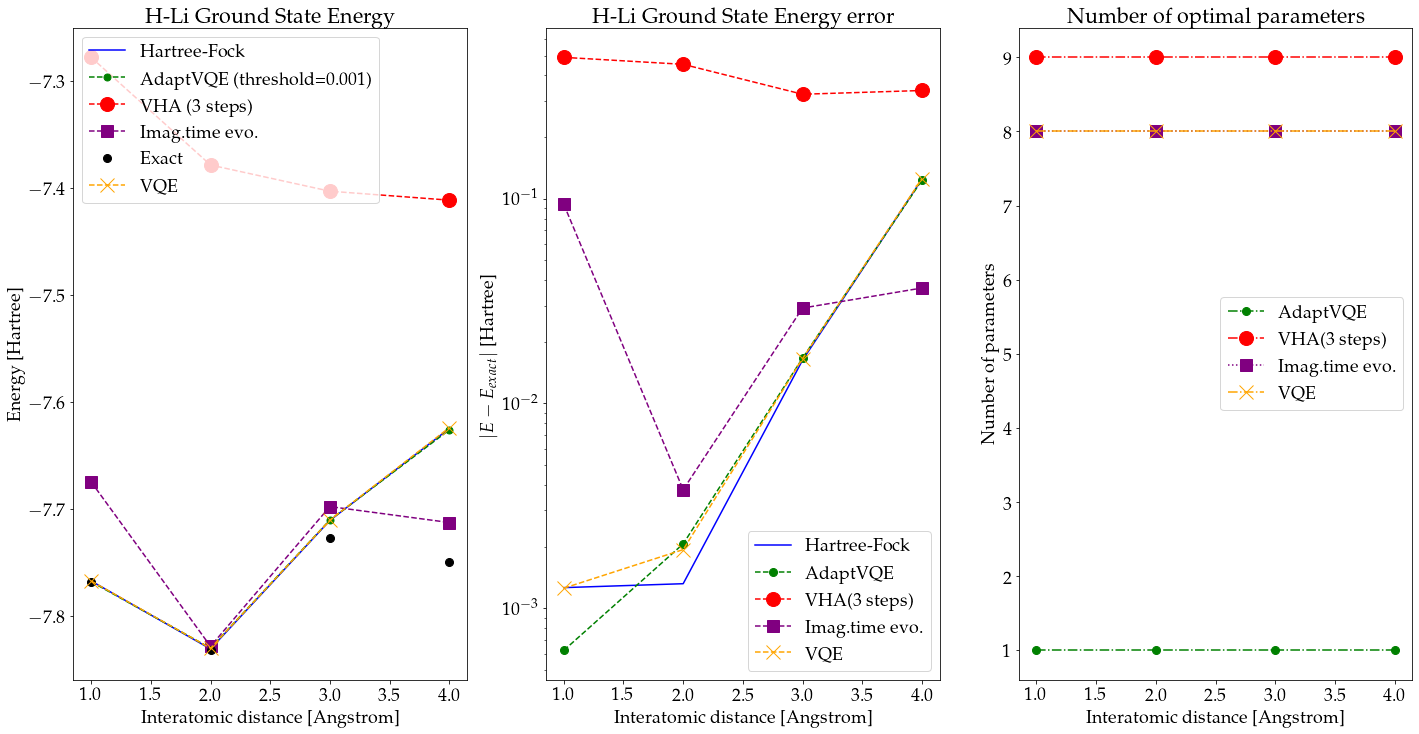

In [26]:

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Palatino"],
    'font.size'   : 18})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 12))

ax1.plot(distances, hf_energies, color='blue', label='Hartree-Fock')
ax1.plot(distances, adapt_vqe_energies, '.',markersize=14,linestyle='--', color='green', label='AdaptVQE (threshold=0.001)')
ax1.plot(distances, vha_energies, 'o',markersize=14,linestyle='--', color='red', label='VHA ('+str(trotter_steps)+' steps)')
ax1.plot(distances, Ievo_energies, 's',markersize=12,linestyle='--', color='purple', label='Imag.time evo.')
ax1.plot(distances, exact_energies, '.',markersize=16, color='black', label='Exact')
ax1.plot(distances, vqe_energies, 'x',markersize=14,linestyle='--', color='orange', label='VQE')
ax1.set_xlabel('Interatomic distance [Angstrom]')
ax1.set_ylabel('Energy [Hartree]')
ax1.set_title('H-Li Ground State Energy')
ax1.legend(loc='upper left')


ypoints = [abs(a - b) for a, b in zip(hf_energies, exact_energies)]
ax2.plot(distances, ypoints, color='blue', label='Hartree-Fock')
ypoints = [abs(a - b) for a, b in zip(adapt_vqe_energies, exact_energies)]
ax2.plot(distances, ypoints, '.',markersize=16, linestyle='--', color='green', label='AdaptVQE')
ypoints = [abs(a - b) for a, b in zip(vha_energies, exact_energies)]
ax2.plot(distances, ypoints, 'o',markersize=14, linestyle='--', color='red', label='VHA('+str(trotter_steps)+' steps)')
ypoints = [abs(a - b) for a, b in zip(Ievo_energies, exact_energies)]
ax2.plot(distances, ypoints, 's',markersize=12, linestyle='--', color='purple', label='Imag.time evo.')
ypoints = [abs(a - b) for a, b in zip(vqe_energies, exact_energies)]
ax2.plot(distances, ypoints, 'x',markersize=14, linestyle='--', color='orange', label='VQE')

ax2.set_yscale('log')
ax2.set_xlabel('Interatomic distance [Angstrom]')
ax2.set_ylabel('$|E-E_{exact}|$ [Hartree]')
ax2.set_title('H-Li Ground State Energy error')
ax2.legend()



ax3.plot(distances, adapt_vqe_params, '.',markersize=16, linestyle='-.', color='green', label='AdaptVQE')
ax3.plot(distances, vha_params, 'o',markersize=14, linestyle='-.', color='red', label='VHA('+str(trotter_steps)+' steps)')
ax3.plot(distances, Ievo_params, 's',markersize=12, linestyle=':', color='purple', label='Imag.time evo.')
ax3.plot(distances, vqe_params, 'x',markersize=14, linestyle='-.', color='orange', label='VQE')

ax3.set_xlabel('Interatomic distance [Angstrom]')
ax3.set_ylabel('Number of parameters')
ax3.set_title('Number of optimal parameters')
ax3.legend()


if usenoise==True: fig.savefig('LiH_ground_energy_noise.pdf')
else: fig.savefig('LiH_ground_energy.pdf')